<h1>ICASSP2019 Tutorial:<br> Detection and Classification of Acoustic Scenes and Events</h1>


Author: **Toni Heittola**

<a href="http://arg.cs.tut.fi/" target="_blank"><em>Audio Research Group / Tampere University</em></a><br>
<a href="mailto:toni.heittola@tuni.fi" target="_blank">[Email]</a>
<a href="http://www.cs.tut.fi/~heittolt/" target="_blank">[Homepage]</a>
<a href="https://github.com/toni-heittola" target="_blank">[Github]</a>

<h1 class="text-muted">Sound event detection with Python</h1>

This notebook demonstrates basic steps needed to build **sound event detection system** using **CRNN** approach.

Key tools used in this example:

- **`dcase_util`** &ndash; used to ease data handling
- **`keras`** &ndash; neural network API for fast experimentation used on top of **`tensorflow`** machine learning framework
- **`sed_eval`** &ndash; evaluation toolbox for sound event detection, here used to evaluate the system output


Jupyter notebook: 
https://github.com/toni-heittola/icassp2019-tutorial

In [2]:
import dcase_util
from dcase_util.containers import AudioContainer
import os, numpy
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import sed_eval
%matplotlib inline

# Handy tool to print data in HTML form
log = dcase_util.ui.FancyHTMLPrinter()

# Paths to store data
data_storage_path = 'data'
dataset_storage_path = os.path.join(data_storage_path, 'datasets')
feature_storage_path = os.path.join(data_storage_path, 'features_sed')
dcase_util.utils.Path().create(
    [data_storage_path, dataset_storage_path, feature_storage_path]
)

# Filename for acoustic model
model_filename = os.path.join(data_storage_path, 'model_sed.h5')  

def get_feature_filename(audio_filename, feature_storage_path):
    return dcase_util.utils.Path(path=audio_filename).modify(
        path_base=feature_storage_path, 
        filename_extension='.npy'
    )
    
def get_feature_matrix(audio_filename, feature_storage_path=os.path.join('data', 'features_sed')):    
    feature_filename = get_feature_filename(audio_filename, feature_storage_path)
    if os.path.exists(feature_filename):
        return numpy.load(feature_filename)
    else:
        audio = dcase_util.containers.AudioContainer().load(filename=audio_filename,mono=True)
        mel_extractor = dcase_util.features.MelExtractor(n_mels=40, win_length_seconds=0.04, hop_length_seconds=0.02, fs=audio.fs)
        mel_data = mel_extractor.extract(y=audio)
        numpy.save(feature_filename, mel_data)
        return mel_data
    
# Setup Keras to use tensorflow as backend
dcase_util.keras.setup_keras(backend='tensorflow')
import keras
from keras.layers import *
from keras.models import Model

# Outline

- Key Python tools used in this example
- Dataset
- Cross-validation set
- Acoustic features
- Learning stage
- Testing stage
- Evaluation

# Dataset

**`dcase_util`** implements dataset handling classes which can be used to access diffently organized dataset through uniform API:

- Download the dataset from the origin, e.g. zenodo.org
- Extract downloaded zip-packages and check data integrity 
- Access meta data (e.g. filter data based on scene labels)
- Access cross-validation sets bundled with the dataset

**TUT Sound Events 2017** development dataset is used in this example. 

In [3]:
db = dcase_util.datasets.TUTSoundEvents_2017_DevelopmentSet(
    data_path=dataset_storage_path
).initialize()

In [4]:
event_labels = db.event_labels()

In [5]:
data = db.meta.stats()
log.table(
    cell_data=[
        data['events']['event_label_list'],
        data['events']['count'],
        data['events']['length'],
        data['events']['avg_length'],
    ],
    column_headers=['Event label', 'Event count', 'Total length', 'Average event length'],
    column_types=['str20', 'int', 'float2', 'float2'],
    scaling=100
)

Event label,Event count,Total length,Average event length
brakes squeaking,52,96.99,1.87
car,304,2471.14,8.13
children,44,350.99,7.98
large vehicle,61,923.74,15.14
people speaking,89,715.66,8.04
people walking,109,1246.95,11.44


## Meta data 

Meta data can be represented as **event list** and **event roll**

1) **Event list** &ndash; list of sound events with onset, offset, and label

In [22]:
event_list = db.meta.filter(filename=db.meta.unique_files[0])

In [23]:
event_list_ = dcase_util.containers.ListDictContainer(event_list[0:5])
onsets = event_list_.get_field('onset')
onsets.append('...')
offsets = event_list_.get_field('offset')
offsets.append('...')
labels = event_list_.get_field('event_label')
labels.append('...')
log.table(
    cell_data=[onsets, offsets, labels],
    column_headers=['Event onset', 'Event offset', 'Event label'],
    column_types=['float2', 'float2', 'str25'],
    scaling=110
)

Event onset,Event offset,Event label
1.59,2.38,people walking
3.50,4.16,people walking
4.16,14.00,car
8.51,11.84,car
14.38,20.00,car
,,...


2) **Event roll** &ndash; binary matrix where event presence is indicated with predefined time resolution, similar to *piano roll* in MIR

In [24]:
mel_extractor = dcase_util.features.MelExtractor(
    n_mels=40, 
    win_length_seconds=0.04,  # 40 ms 
    hop_length_seconds=0.02,  # 20 ms
    fs=44100
)

# Event roll syncronized with feature extraction
event_roll = event_list.to_event_roll(
    time_resolution=mel_extractor.hop_length_seconds, 
    label_list=db.event_labels()
)

In [25]:
print('event_roll shape', '(classes, time)', event_roll.shape)

event_roll shape (classes, time) (6, 8803)


### Event roll visualized together with acoustic features

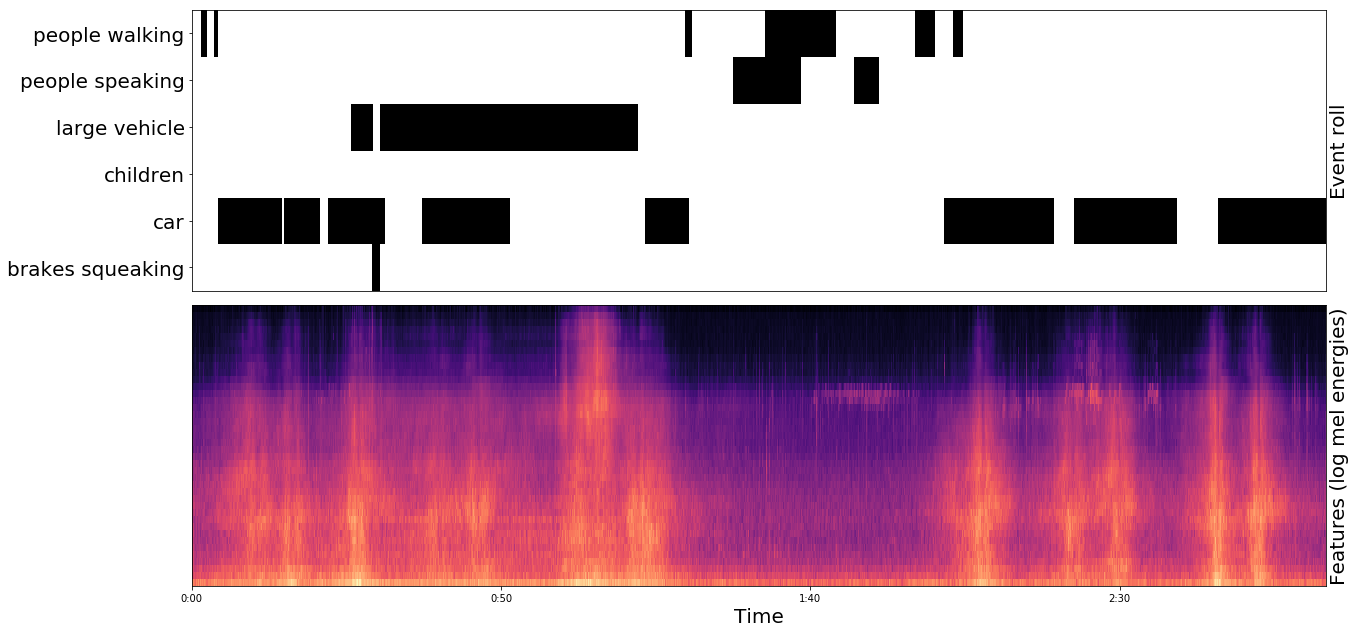

In [11]:
audio = AudioContainer().load(
    filename=db.meta.unique_files[0],
    mono=True
)
mel_data = mel_extractor.extract(y=audio)
feature_container = dcase_util.containers.FeatureContainer(
    data=mel_data, 
    time_resolution=mel_extractor.hop_length_seconds
)
event_roll.plot(
    data_container=feature_container, 
    figsize=(18, 8), 
    data_panel_title='Features (log mel energies)', 
    binary_panel_title='Event roll',
    panel_title_position='right'
)

# Cross-validation set

Dataset is bundled with **4-fold** cross-validation set (train/test), in this example we use only first fold

**Validation set** is split from training set to have similar event distribution, however, recordings contain variable amount of events:
- Place recordings either into training or validation set 
- Measure distance of event counts to target split percentage (70/30)
- Select best match after multiple trials
- Split can be done with dataset handling class from `dcase_util` 

In [6]:
current_fold = 1
training_files, validation_files = db.validation_split(
    validation_amount=0.3, 
    fold=current_fold, 
    iterations=50,
    disable_progress_bar=True
)
train_meta = db.train(current_fold).filter(file_list=training_files)
validation_meta = db.train(current_fold).filter(file_list=validation_files)

### Train / Validation / Test statistics

**Recordings**

In [19]:
print('Training files         :', len(training_files))
print('Validation files       :', len(validation_files))
print('Validation file amount :', '{0:2.2f}%'.format(
    len(validation_files) / float(len(validation_files) + len(training_files))* 100.0))

Training files         : 12
Validation files       : 6
Validation file amount : 33.33%


**Events**

In [14]:
train_items = train_meta.stats()['events']['count']
train_items = numpy.append(train_items, numpy.sum(train_items))

validation_items = validation_meta.stats()['events']['count']
validation_items = numpy.append(validation_items, numpy.sum(validation_items))

test_items = db.eval(1).stats()['events']['count']
test_items = numpy.append(test_items, numpy.sum(test_items))

labels = db.event_labels() 
labels.append('Overall')

log.table(
    cell_data=[
        labels, 
        train_items,         
        validation_items,  
        validation_items / (train_items + validation_items) * 100.0,
        #test_items
    ],
    column_headers=['Event label', 'Train set (events)', 'Validation set (events)', 'Validation data amount (%)', 
                    #'Test set (events)',
                   ],
    column_types=['str25', 'int', 'int', 'float1', 'int', 'int', 'int', 'int', 'int'],
    column_separators=[0,2],
    row_separators=[6],
    scaling=90
)

Event label,Train set (events),Validation set (events),Validation data amount (%)
brakes squeaking,32,13,28.9
car,162,84,34.1
children,31,8,20.5
large vehicle,38,10,20.8
people speaking,57,15,20.8
people walking,59,26,30.6
Overall,379,156,29.2


# Learning acoustic model

For each learning example, we need **feature matrix** and **target matrix** (event roll)

Data is split into fixed length **sequences** (5 seconds, non-overlapping)

1) **Feature** matrix:

In [26]:
# Extract features
features = mel_extractor.extract(
    AudioContainer().load(filename=train_meta.unique_files[2], mono=True)
)
# Split feature matrix into sequences
sequence_length = 250                              # 5s/0.02s=250 frames
data_sequencer = dcase_util.data.Sequencer(
    sequence_length=sequence_length
) 
sequences = data_sequencer.sequence(features).data # (40, 250, 60)
# Reshape matrix to have sequences at first axis
X = numpy.moveaxis(sequences, 2, 0)

In [27]:
print('Data shape', '(sequence, frequency, time)', X.shape)

Data shape (sequence, frequency, time) (60, 40, 250)


2) **Target** matrix (event roll):

In [28]:
# Get event list for the current item 
event_list = train_meta.filter(filename=train_meta.unique_files[2]) 

# Time resolution of feature extraction
feature_matrix_time_resolution = mel_extractor.hop_length_seconds
# Feature matrix length (seconds), needed to make event roll same size
feature_matrix_length = features.shape[1]*mel_extractor.hop_length_seconds

# Translate event list into event roll
event_roll = event_list.to_event_roll(
    label_list=db.event_labels(),                      # Event labels
    time_resolution=feature_matrix_time_resolution,
    length_seconds=feature_matrix_length
)

# Reshape matrix to have sequences at first axis
Y = numpy.moveaxis(data_sequencer.sequence(event_roll).data, 2, 0)


In [29]:
print('Data shape', '(sequence, event classes, time)', Y.shape)

Data shape (sequence, event classes, time) (60, 6, 250)


## Collect training data

In [31]:
X_train = []
Y_train = []
for audio_filename in train_meta.unique_files:
    print('Load', db.absolute_to_relative_path(audio_filename))
    
    # Extract features, load them from file if they exists, if not extract and save
    features = get_feature_matrix(audio_filename, feature_storage_path)
    feature_sequence = data_sequencer.sequence(features)
    # Extract features, store only in memory
    #features = mel_extractor.extract(
    #    dcase_util.containers.AudioContainer().load(filename=item.filename,mono=True)
    #)

    # Targets
    event_list = train_meta.filter(filename=audio_filename)
    event_roll = event_list.to_event_roll(
        label_list=db.event_labels(),                                       # Event labels
        time_resolution=mel_extractor.hop_length_seconds,                   # Time resolution of feature matrix
        length_seconds=features.shape[1]*mel_extractor.hop_length_seconds   # Length of original audio signal
    )
    target_matrix = data_sequencer.sequence(event_roll)
    
    X_train.append(numpy.moveaxis(feature_sequence.data,2,0)) 
    Y_train.append(numpy.moveaxis(target_matrix.data,2,0))
    
X_train = numpy.vstack(X_train)
Y_train = numpy.vstack(Y_train)
print('----------------------')
print('X_train shape', X_train.shape)
print('Y_train shape', Y_train.shape)

Load audio/street/a008.wav
Load audio/street/a012.wav
Load audio/street/a124.wav
Load audio/street/a127.wav
Load audio/street/a128.wav
Load audio/street/a131.wav
Load audio/street/b006.wav
Load audio/street/b007.wav
Load audio/street/b009.wav
Load audio/street/b091.wav
Load audio/street/b093.wav
Load audio/street/b095.wav
----------------------
X_train shape (571, 40, 250)
Y_train shape (571, 6, 250)


In [32]:
X_validation = []
Y_validation = []
validation_data = {}
for audio_filename in validation_meta.unique_files:
    print('Load', db.absolute_to_relative_path(audio_filename))
    
    # Extract features, load them from file if they exists, if not extract and save
    features = get_feature_matrix(audio_filename, feature_storage_path)
    feature_sequence = data_sequencer.sequence(features)
    # Extract features, store only in memory
    #features = mel_extractor.extract(
    #    dcase_util.containers.AudioContainer().load(filename=item.filename,mono=True)
    #)

    # Targets
    event_list = validation_meta.filter(filename=audio_filename)
    event_roll = event_list.to_event_roll(
        label_list=db.event_labels(),                                       # Event labels
        time_resolution=mel_extractor.hop_length_seconds,                   # Time resolution of feature matrix
        length_seconds=features.shape[1]*mel_extractor.hop_length_seconds   # Length of original audio signal
    )
    target_matrix = data_sequencer.sequence(event_roll)
    
    X_validation.append(numpy.moveaxis(feature_sequence.data,2,0)) 
    Y_validation.append(numpy.moveaxis(target_matrix.data,2,0))
    
    validation_data[audio_filename] = {
        'features': features,
        'meta': event_list
    }
        
X_validation = numpy.vstack(X_validation)
Y_validation = numpy.vstack(Y_validation)
print('----------------------')
print('X_validation shape', X_validation.shape)
print('Y_validation shape', Y_validation.shape)

Load audio/street/a001.wav
Load audio/street/a003.wav
Load audio/street/b003.wav
Load audio/street/b005.wav
Load audio/street/b094.wav
Load audio/street/b098.wav
----------------------
X_validation shape (268, 40, 250)
Y_validation shape (268, 6, 250)


## Learning data

All learning data is collected into X_train and Y_train matrices:

In [33]:
print('X_train shape', '(sequence, frequency    , time)', X_train.shape)
print('Y_train shape', '(sequence, event classes, time)', Y_train.shape)

X_train shape (sequence, frequency    , time) (571, 40, 250)
Y_train shape (sequence, event classes, time) (571, 6, 250)


Matrix data:

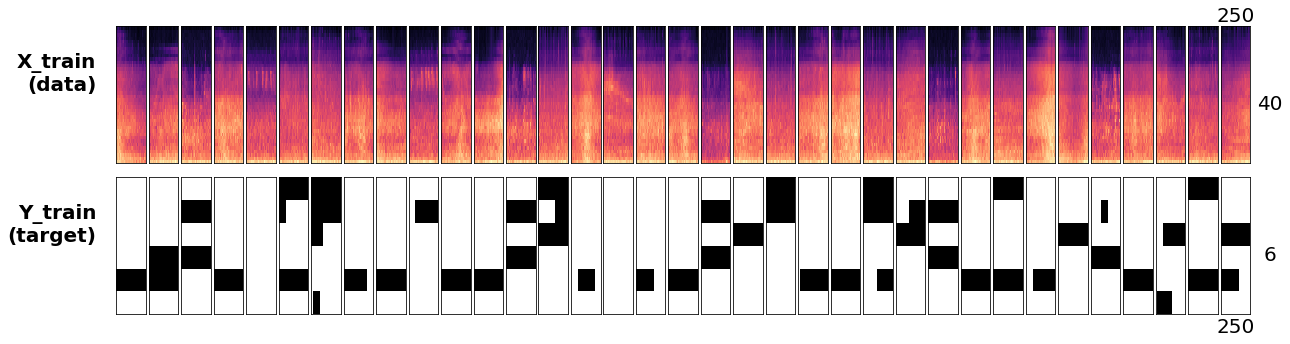

In [34]:
example_ids = numpy.random.choice(range(X_train.shape[0]), 35, replace=False)

fig, axes = plt.subplots(2, len(example_ids), figsize=(18, 4))
fig.subplots_adjust(top=1.0, bottom=0.0, right=1.0, hspace=0.1, wspace=0.1)

for i, item_id in enumerate(example_ids):
    current_x = X_train[item_id,:,:]
    current_y = Y_train[item_id,:,:]
        
    plt.sca(axes[0, i])
    dcase_util.containers.FeatureContainer(current_x).plot(plot=False)
    
    plt.sca(axes[1, i])
    dcase_util.containers.BinaryMatrix2DContainer(current_y).plot(plot=False)

axes[0, -1].yaxis.set_label_position("right")
axes[0, -1].xaxis.set_label_position("top")
axes[0, -1].set_ylabel('40', rotation=0, fontsize=20, labelpad=20)
axes[0, -1].set_xlabel('250',fontsize=20)

axes[1, -1].yaxis.set_label_position("right")
axes[1, -1].xaxis.set_label_position("bottom")
axes[1, -1].set_ylabel('6', rotation=0, fontsize=20, labelpad=20)
axes[1, -1].set_xlabel('250',fontsize=20)

axes[0, 0].set_ylabel('X_train\n(data)', rotation=0, fontsize=20, labelpad=20, fontweight='bold', ha='right')
axes[1, 0].yaxis.set_label_position("left")
axes[1, 0].set_ylabel('Y_train\n(target)', rotation=0, fontsize=20, labelpad=20, fontweight='bold', ha='right')    

axes[0, i].yaxis.label.set_visible(True)
axes[1, i].yaxis.label.set_visible(True)

# Neural network structure

Next we create **CRNN** styled neural network structure layer by layer


**Input** layer and **Reshaping** layer to add channel axis into input to match `channels_last` mode:

In [35]:
feature_vector_length = mel_extractor.n_mels   # Number of mel bands

In [36]:
input_layer = Input(
    shape=(feature_vector_length, sequence_length), 
    name='Input'
)
x = Reshape(
    target_shape=(feature_vector_length, sequence_length, 1), 
    name='Input_Reshape'
)(input_layer)


In [37]:
print('Output shape','(sequence, frequency, time, channel)', x._keras_shape)

Output shape (sequence, frequency, time, channel) (None, 40, 250, 1)


**Two convolutional groups** are used to capture small shifts in time and frequency. 

Similar groups as in sound classification example, except max **pooling done only along frequency** axis as time axis is retained for the detection.


- **Convolution** to extract high-level features (kernel 3x3 and 64 filters)
- **Batch normalization** to enable higher learning rates
- **Activation** (ReLu)
- **Pooling** along frequency axis to extract dominant features
- **Dropout** to avoid overfitting

**Convolutional group 1**

In [38]:
print('Input shape','(sequence, frequency, time, channel)', x._keras_shape)

Input shape (sequence, frequency, time, channel) (None, 40, 250, 1)


In [39]:
# Convolution
x = Conv2D(filters=64, kernel_size=(3, 3), activation='linear',
           padding='same', data_format='channels_last', name='Conv1')(x)
# Batch normalization
x = BatchNormalization(axis=-1, name='Conv1_BatchNorm')(x)
# Activation
x = Activation(activation='relu', name='Conv1_Activation')(x)
# Max pooling along frequency axis
x = MaxPooling2D(pool_size=(5, 1), name='Conv1_Pooling')(x)
# Drop out
x = Dropout(rate=0.2, name='Conv1_DropOut')(x)


In [40]:
print('Output shape', '(sequence, frequency, time, feature)', x._keras_shape)

Output shape (sequence, frequency, time, feature) (None, 8, 250, 64)


**Convolutional group 2**

In [41]:
print('Input shape','(sequence, frequency, time, channel)', x._keras_shape)

Input shape (sequence, frequency, time, channel) (None, 8, 250, 64)


In [42]:
# Convolution
x = Conv2D(filters=64, kernel_size=(3, 3), activation='linear',
           padding='same', data_format='channels_last', name='Conv2')(x)
# Batch normalization
x = BatchNormalization(axis=-1, name='Conv2_BatchNorm')(x)
# Activation
x = Activation(activation='relu', name='Conv2_Activation')(x)
# Max pooling along frequency axis
x = MaxPooling2D(pool_size=(4, 1), name='Conv2_Pooling')(x)
# Drop out
x = Dropout(rate=0.2, name='Conv2_DropOut')(x)


In [43]:
print('Output shape', '(sequence, frequency, time, feature)', x._keras_shape)

Output shape (sequence, frequency, time, feature) (None, 2, 250, 64)


To **connect** convolutional layers and recurrent layers, output of the last convolutional group has to be  **Reordered** and **Reshaped**:

In [44]:
print('Input shape', '(sequence, frequency, time, feature)', x._keras_shape)

Input shape (sequence, frequency, time, feature) (None, 2, 250, 64)


In [45]:
x = Permute(
    dims=(1, 3, 2), 
    name='Permute'
)(x)

x = Reshape(
    target_shape=(sequence_length, -1), 
    name='Reshape'
)(x)


In [46]:
print('Output shape', '(sequence, time, feature)', x._keras_shape)

Output shape (sequence, time, feature) (None, 250, 128)


Two **bidirectional** **recurrent** layers (Gated Recurrent Units) are used to integrate information from large time window:

In [47]:
print('Input shape', '(sequence, time, feature)', x._keras_shape)

Input shape (sequence, time, feature) (None, 250, 128)


In [48]:
x = Bidirectional(
    GRU(
        units=32, activation='tanh', 
        dropout=0.2, recurrent_dropout=0.2, 
        return_sequences=True
    ), merge_mode='mul', name='Recurrent_1'
)(x)
x = Bidirectional(
    GRU(units=32, activation='tanh', 
        dropout=0.2, recurrent_dropout=0.2, 
        return_sequences=True
    ), merge_mode='mul', name='Recurrent_2'
)(x)

In [49]:
print('Output shape', '(sequence, time, feature)', x._keras_shape)

Output shape (sequence, time, feature) (None, 250, 32)


**Recognition** is done with two **fully-connected** layers using information extracted by the previous layers. 

Layers are wrapped with `TimeDistributed` class to apply layers independently to each time step.

**Output layer** (last fully-connected layer) is with sigmoid activation.

In [50]:
x = TimeDistributed(
    Dense(units=32), name='FC'
)(x)
x = Dropout(rate=0.2, name='FC_DropOut')(x)
x = TimeDistributed(
    Dense(units=len(db.event_labels())), name='Output'
)(x)
output_layer = Activation('sigmoid', name='Output_Activation')(x)

In [51]:
print('Output shape', '(sequence, time, classes)', output_layer._keras_shape)

Output shape (sequence, time, classes) (None, 250, 6)


Create a model network:

In [52]:
model = Model(inputs=input_layer, outputs=output_layer)

In [53]:
dcase_util.keras.model_summary_string(
    keras_model=model,
    mode='extended', 
    show_parameters=False, 
    display=True
) # alternative for print(model.summary()) to get html table

Layer name,Layer type,Output shape,Parameters
Input,InputLayer,"(None, 40, 250)",0
Input_Reshape,Reshape,"(None, 40, 250, 1)",0
Conv1,Conv2D,"(None, 40, 250, 64)",640
Conv1_BatchNorm,BatchNorm,"(None, 40, 250, 64)",256
Conv1_Activation,Activation,"(None, 40, 250, 64)",0
Conv1_Pooling,MaxPooling2D,"(None, 8, 250, 64)",0
Conv1_DropOut,Dropout,"(None, 8, 250, 64)",0
Conv2,Conv2D,"(None, 8, 250, 64)",36928
Conv2_BatchNorm,BatchNorm,"(None, 8, 250, 64)",256
Conv2_Activation,Activation,"(None, 8, 250, 64)",0


## Training

One should evaluate validation data with **same metric** which is used in actual system evaluation with test set 

For sound event detection, `keras` does not provide any suitable metric (such as *segment-based error rate (ER)* or *f-score (F1)*)

Default `keras` training process needs to be modified by halting it after each epoch:
- Validation data is evaluated with current model **outside the training process**
- Metric values are stored and used to control the training process (e.g. model selection or early stopping)

## Callbacks

In [42]:
epochs = 100
keras_metric = 'binary_accuracy'
keras_loss = 'binary_crossentropy'
metric_to_monitor = 'ER'
external_metrics = {
    'ER': 'Error rate',
    'F1': 'F-score'
}

callback_list = [
    dcase_util.keras.ProgressLoggerCallback(
        epochs=epochs,
        metric=keras_metric,
        loss=keras_loss,
        output_type='console',
        show_timing=False,
        manual_update=True,
        external_metric_labels=external_metrics        
    ),
    #dcase_util.keras.StopperCallback(
    #    epochs=epochs,
    #    monitor=metric_to_monitor,
    #    patience=10,
    #    initial_delay=50,
    #    min_delta=0,
    #    manual_update=True,
    #    external_metric_labels=external_metrics
    #),
    dcase_util.keras.StasherCallback(
        epochs=epochs,
        monitor=metric_to_monitor,
        initial_delay=50,
        manual_update=True,
        external_metric_labels=external_metrics
    )
]

In [43]:
from keras.optimizers import Adam
model.compile(
    loss=keras_loss,
    metrics=[keras_metric],
    optimizer=Adam(lr=0.001, decay=0.001)
)

In [44]:
# Reorder target to fit model
Y_train = numpy.moveaxis(Y_train, 1, 2)
Y_validation = numpy.moveaxis(Y_validation, 1, 2)

print('X_train shape', X_train.shape)
print('Y_train shape', Y_train.shape)
print('X_validation shape', X_validation.shape)
print('Y_validation shape', Y_validation.shape)

X_train shape (571, 40, 250)
Y_train shape (571, 250, 6)
X_validation shape (268, 40, 250)
Y_validation shape (268, 250, 6)


In [45]:
# Variable to training history including metrics calculated outside keras
history = {
    'loss': [],
    'val_loss': [],
    'val_er': [],
    'val_f1': [],
}

# Do training epoch by epoch
for epoch_start in range(0, epochs):
    epoch_end = epoch_start + 1

    # Make sure we have only specified amount of epochs
    if epoch_end > epochs:
        epoch_end = epochs

    # Train model
    model.fit(
        x=X_train,
        y=Y_train,
        validation_data=(X_validation, Y_validation),
        callbacks=callback_list,
        verbose=0,
        initial_epoch=epoch_start,
        epochs=epoch_end,
        batch_size=8,
        shuffle=True
    )
    
    # Initialize evaluator
    evaluator = sed_eval.sound_event.SegmentBasedMetrics(
        event_label_list=db.event_labels(),
        time_resolution=1.0,
    )
    
    # Go through all validation files, do detection and accumulate intermediate statistics for metric calculation
    for audio_filename, validation_item in validation_data.items():
        # Get input features
        input_data = data_sequencer.sequence(validation_item['features']).data
        input_data = numpy.moveaxis(input_data, 2, 0)
        
        # Get per frame probabilities in sequences (3D matrix)
        item_probabilities_seq = model.predict(x=input_data)
        # Merge sequences together (2D matrix)
        item_probabilities = numpy.vstack(item_probabilities_seq)

        # Binarization 
        event_activity = dcase_util.data.ProbabilityEncoder().binarization(
            probabilities=item_probabilities,
            binarization_type='global_threshold',
            threshold=0.5
        )
        
        # Get list of detected events
        current_estimated = dcase_util.containers.MetaDataContainer()
        for event_id, event_label in enumerate(db.event_labels()):
            # Convert active frames into segments and translate frame indices into timestamps
            event_segments = dcase_util.data.DecisionEncoder().find_contiguous_regions(
                activity_array=event_activity[:, event_id]
            ) * 0.02

            # Form event items
            for event in event_segments:
                current_estimated.append(
                    {
                        'filename': db.absolute_to_relative_path(audio_filename),
                        'onset': event[0],
                        'offset': event[1],
                        'event_label': event_label
                    }
                )
                
        # Accumulate evaluator with current file
        evaluator.evaluate(
            reference_event_list=validation_item['meta'],
            estimated_event_list=current_estimated
        )

    # Calculate metrics
    overall_metrics = evaluator.results_overall_metrics()
    er = overall_metrics['error_rate']['error_rate']
    fscore = overall_metrics['f_measure']['f_measure']

    # Inject external metric values to the callbacks
    for callback in callback_list:
        if hasattr(callback, 'set_external_metric_value'):
            callback.set_external_metric_value(
                metric_label='ER',
                metric_value=er
            )
            callback.set_external_metric_value(
                metric_label='F1',
                metric_value=fscore
            )

    # Store metrics
    history['loss'].append(model.history.history['loss'])
    history['val_loss'].append(model.history.history['val_loss'])
    history['val_er'].append(er)
    history['val_f1'].append(fscore)

    # Manually update callbacks
    for callback in callback_list:
        if hasattr(callback, 'update'):
            callback.update()

    # Check if we need to stop training
    stop_training = False
    for callback in callback_list:
        if hasattr(callback, 'stop'):
            if callback.stop():
                stop_training = True
                break

    if stop_training:
        # Stop the training loop
        break

# Manually update callbacks
for callback in callback_list:
    if hasattr(callback, 'close'):
        callback.close()

  Training
            Loss                      Metric                    Ext. metrics                                  
            binary_crossentropy       binary_accuracy                                                         
  Epoch     Train        Val          Train        Val          Error rate     F-score       
  -------   ----------   ----------   ----------   ----------   ------------   ------------  
  1         0.4672       0.3305       0.7875       0.8651       1.0000                       
  2         0.4532       0.3481       0.7907       0.8651       1.0000                       
  3         0.4412       0.3372       0.7923       0.8654       0.9785         0.0444        
  4         0.4306       0.3541       0.7893       0.8651       1.0000                       
  5         0.4201       0.3385       0.7949       0.8590       1.0713         0.0460        
  6         0.4025       0.3268       0.8055       0.8732       0.8136         0.3560        
  7         0.3

## Best performing model

Best performing model was stored during the training process in `StasherCallback`:

In [46]:
for callback in callback_list:
    if isinstance(callback, dcase_util.keras.StasherCallback):                
        model.set_weights(callback.get_best()['weights'])       # Fetch the best performing model        
        callback.show()                                         # Show information
        break

Save model and training history:

In [47]:
# Save model
model.save(model_filename)

# Save training history
dcase_util.files.Serializer().save_cpickle(
    filename=os.path.join(data_storage_path, 'model_sed_training_history.cpickle'),
    data=history
)

## Training history

In [4]:
hist = dcase_util.files.Serializer().load_cpickle(filename=os.path.join(data_storage_path, 'model_sed_training_history.cpickle'))

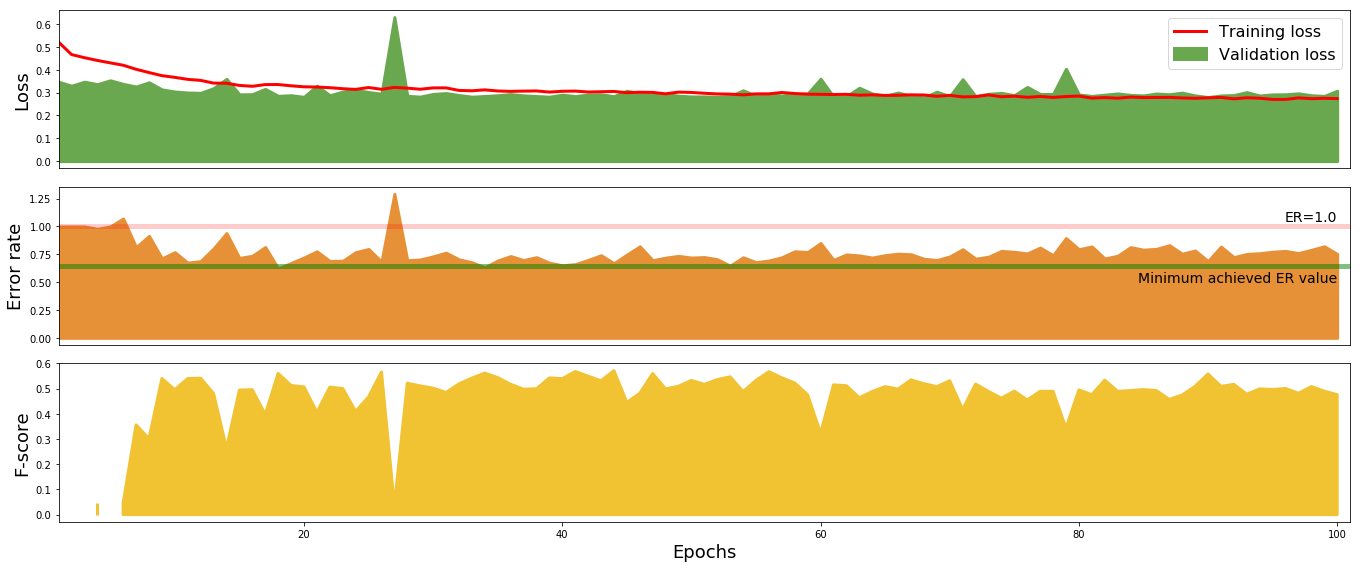

In [57]:
epochs = range(1, len(hist['loss']) + 1)
fig = plt.figure(figsize=(19,8))

plt.subplot(3,1,1)
plt.plot(epochs, hist['loss'], color='red', linewidth=3, label='Training loss')
#plt.plot(epochs, hist['val_loss'], color='green', linewidth=3, label='Validation loss')
plt.fill_between(epochs, numpy.squeeze(numpy.array(hist['val_loss'])), color='#6aa84f', linewidth=3, label='Validation loss')
plt.ylabel('Loss', fontsize=18)
plt.legend(loc='best', fontsize=16)
panel = plt.gca()
panel.set_xlim([1,len(hist['loss']) + 1])
panel.get_xaxis().set_visible(False)

plt.subplot(3,1,2)
plt.fill_between(epochs, hist['val_er'], color='#e69138', linewidth=3, label='Error rate')
plt.axhline(y=1, color='red', linestyle='-', linewidth=5, alpha=0.2)
plt.ylabel('Error rate', fontsize=18)
er_min_index = numpy.argmin(hist['val_er'][50:])+50
plt.axhline(hist['val_er'][er_min_index], color='green', linestyle='-', linewidth=5, alpha=0.5) #'o', markersize=10, color='red')
plt.annotate('Minimum achieved ER value', xy=(len(hist['loss']),hist['val_er'][er_min_index]-0.15), fontsize=14, ha='right')
plt.annotate('ER=1.0', xy=(len(hist['loss']),1+0.05), fontsize=14, ha='right')
panel = plt.gca()
panel.set_xlim([1,len(hist['loss']) + 1])
panel.get_xaxis().set_visible(False)

plt.subplot(3,1,3)
plt.fill_between(epochs, hist['val_f1'], color='#f1c232', linewidth=3, label='F-score')
plt.ylabel('F-score', fontsize=18)
plt.xlabel('Epochs', fontsize=18)
panel = plt.gca()
panel.set_xlim([1,len(hist['loss']) + 1])
plt.tight_layout()
plt.show()

# Testing stage

In [4]:
model = keras.models.load_model(model_filename) # Load model

# Feature extractor and data sequencer are initialized here also to be able to run only testing stage.
mel_extractor = dcase_util.features.MelExtractor(
    n_mels=40, 
    win_length_seconds=0.04,  # 40 ms 
    hop_length_seconds=0.02,  # 20 ms
    fs=44100
)

sequence_length = 250                              # 5s/0.02s=250 frames
data_sequencer = dcase_util.data.Sequencer(
    sequence_length=sequence_length
) 

current_fold = 1

**Extract features** for a test item:

In [51]:
item = db.test(fold=1)[0]
# Extract features
features = mel_extractor.extract(
    dcase_util.containers.AudioContainer().load(filename=item.filename, mono=True)
)
# Split feature matrix into sequences
features_sequenced = data_sequencer.sequence(features).data # (40, 250, 48)
# Reshape matrix to have sequences at first axis
input_data = numpy.moveaxis(features_sequenced, 2, 0)

In [52]:
print('input_data shape', '(sequence, frequency, time)', input_data.shape)

input_data shape (sequence, frequency, time) (48, 40, 250)


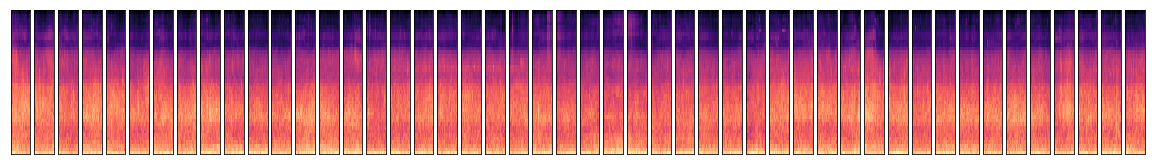

In [53]:
fig, axes = plt.subplots(1, input_data.shape[0], figsize=(18, 2))
fig.subplots_adjust(top=1.0, bottom=0.0, right=1.0, hspace=0.00, wspace=0.2)
for i in range(input_data.shape[0]):
    current_sequence = input_data[i,:,:]
    plt.sca(axes[i])
    dcase_util.containers.FeatureContainer(current_sequence).plot(plot=False)

Feed features into model to get probabilities for each event class per frame:

In [54]:
# Get per frame probabilities in sequences (3D matrix)
item_probabilities_seq = model.predict(x=input_data)       

# Merge sequences together (2D matrix)
item_probabilities = numpy.vstack(item_probabilities_seq)

In [55]:
print('item_probabilities shape', '(time, classes)', item_probabilities.shape)

item_probabilities shape (time, classes) (12000, 6)


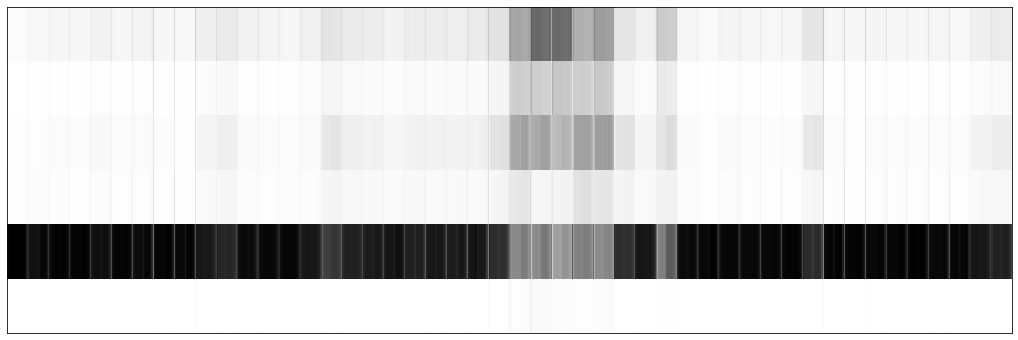

In [56]:
plt.figure(figsize=(18,6))
plt.imshow(item_probabilities.T, aspect='auto', cmap=plt.cm.gray_r, origin='lower')
axes = plt.gca()
axes.axes.get_xaxis().set_visible(False)
axes.axes.get_yaxis().set_visible(False)
plt.show()

**Event activities** per frame (event roll) are acquired by thresholding probability matrix with 0.5:

In [57]:
event_activity = dcase_util.data.ProbabilityEncoder().binarization(
    probabilities=item_probabilities, 
    threshold=0.5,
    binarization_type='global_threshold'
)

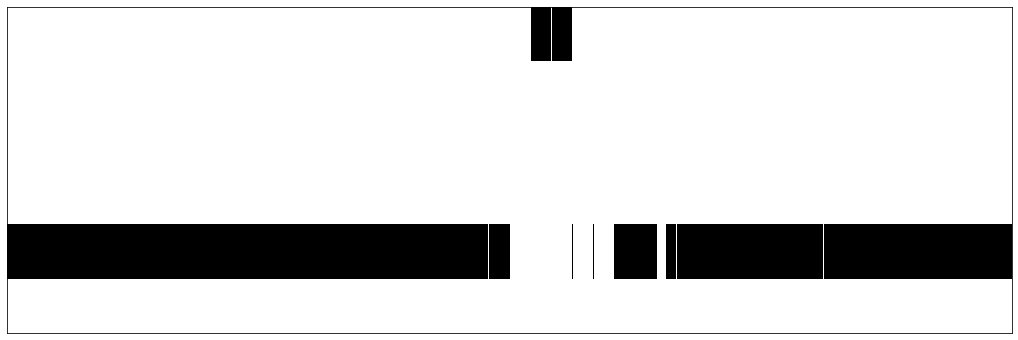

In [58]:
plt.figure(figsize=(18,6))
plt.imshow(event_activity.T, aspect='auto',cmap=plt.cm.gray_r, origin='lower')
axes = plt.gca()
axes.axes.get_xaxis().set_visible(False)
axes.axes.get_yaxis().set_visible(False)
plt.show()

**Event list** is formed from event activity matrix by finding contiguous regions per class:

In [59]:
current_estimated = dcase_util.containers.MetaDataContainer()
# Process per event class
for event_id, event_label in enumerate(db.event_labels()):
    # Get active segments with start and stop frame index
    event_segments = dcase_util.data.DecisionEncoder().find_contiguous_regions(
        activity_array=event_activity[:, event_id]
    )
    # Translate frame indices into timestamps
    event_segments = event_segments * mel_extractor.hop_length_seconds
    # Loop through found active segments and create events
    for event in event_segments:
        current_estimated.append({
                'filename': db.absolute_to_relative_path(item.filename),
                'onset': event[0],
                'offset': event[1],
                'event_label': event_label
        })
# Merge events together from same class which are within 100ms
current_estimated = current_estimated.process_events(minimum_event_gap=0.1)
# Remove events which are < 100ms 
current_estimated = current_estimated.process_events(minimum_event_length=0.250)

**System output** versus **Reference**

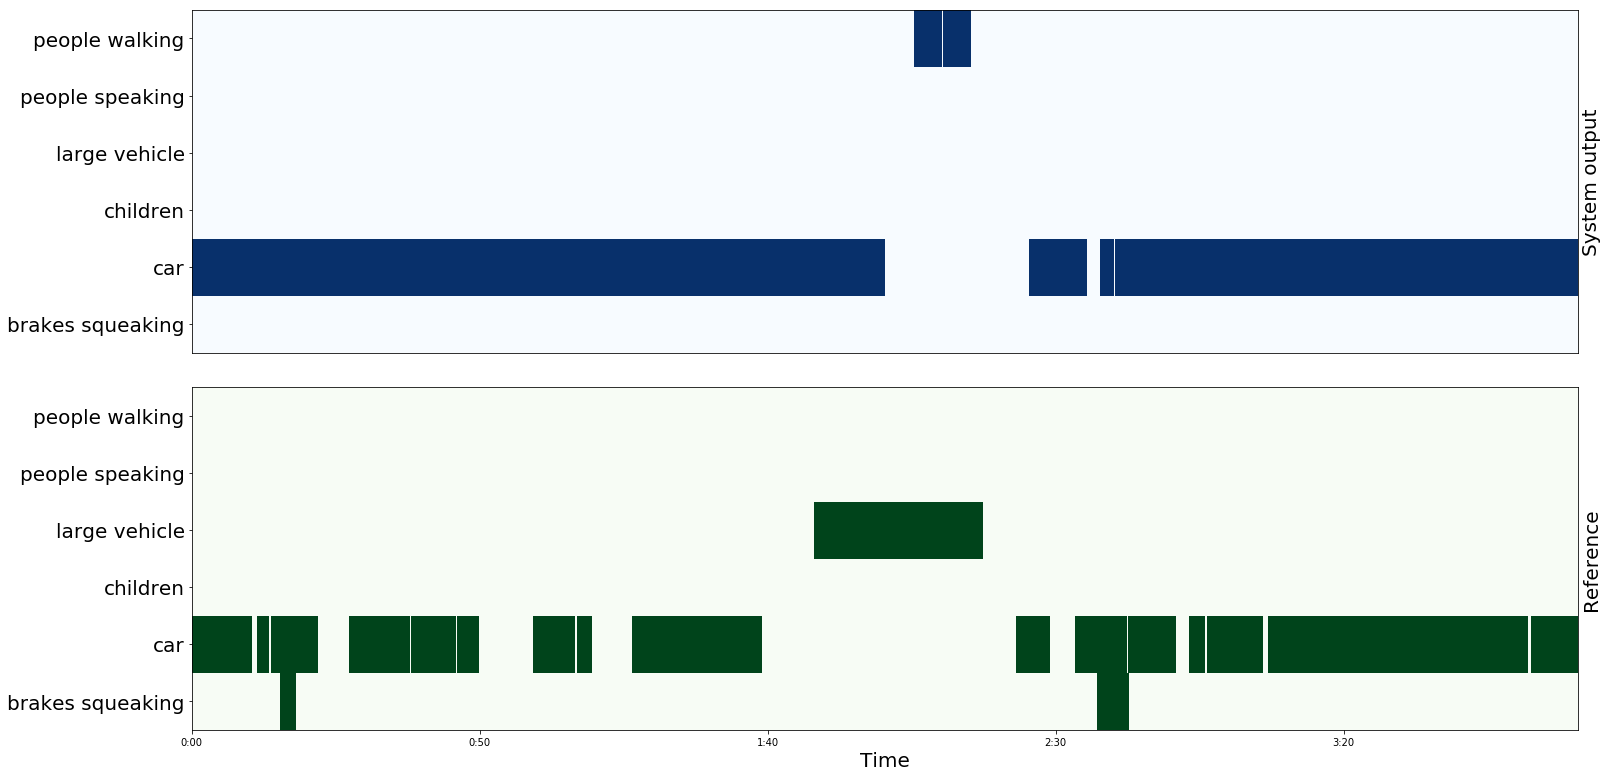

In [60]:
fig, axes = plt.subplots(2, 1, figsize=(22, 10))
fig.subplots_adjust(top=1.0, bottom=0.0, right=1.0, hspace=0.10, wspace=0.00)
plt.sca(axes[0])
current_estimated.to_event_roll(label_list=db.event_labels()).plot(
    figsize=(18,3), color='blue', plot=False, panel_title='System output'
)
axes[0].get_xaxis().set_visible(False)
plt.sca(axes[1])
current_meta = db.meta.filter(filename=item.filename)
current_meta.to_event_roll(label_list=db.event_labels()).plot(
    figsize=(18,3), color='green', plot=False, panel_title='Reference'
)

## Going through all test material

In [5]:
res = dcase_util.containers.MetaDataContainer(filename=os.path.join(data_storage_path, 'results_sed.csv'))

for item in tqdm(db.test(fold=current_fold)):
    # Load features
    features = get_feature_matrix(item.filename)
    features_sequenced = data_sequencer.sequence(features).data
    input_data = numpy.moveaxis(features_sequenced, 2, 0) # Rearrange axes => (sequence, feature vector, time)
    
    # Get network output
    item_probabilities_seq = model.predict(x=input_data)        # Get per frame probabilities in sequences (3D matrix)
    item_probabilities = numpy.vstack(item_probabilities_seq)   # Merge sequences together (2D matrix)

    # Event activity
    event_activity = dcase_util.data.ProbabilityEncoder().binarization(
        probabilities=item_probabilities,
        binarization_type='global_threshold',
        threshold=0.5
    )
    current_estimated = dcase_util.containers.MetaDataContainer()
    for event_id, event_label in enumerate(db.event_labels()):
        # Convert active frames into segments and translate frame indices into timestamps
        event_segments = dcase_util.data.DecisionEncoder().find_contiguous_regions(
            activity_array=event_activity[:, event_id]
        ) * 0.02

        # Form event items
        for event in event_segments:
            current_estimated.append(
                {
                    'filename': db.absolute_to_relative_path(item.filename),
                    'onset': event[0],
                    'offset': event[1],
                    'event_label': event_label
                }
            )
            
        # Merge events together from same class which are within 100ms
        current_estimated = current_estimated.process_events(minimum_event_gap=0.1)
        # Remove events which are < 100ms 
        current_estimated = current_estimated.process_events(minimum_event_length=0.1)
        
    # Store result into results container
    res += current_estimated
    
# Save results container
res.save().show(mode='print')


MetaDataContainer :: Class
Filename                            : data/results_sed.csv 
Items                               : 94 
Unique
  Files                             : 6 
  Scene labels                      : 0 
  Event labels                      : 5 
  Tags                              : 0 
  Identifiers                       : 0 
  Source labels                     : 0 

Event statistics
  Event label             Count   Tot. Length   Avg. Length   
  --------------------   ------   -----------   -----------   
  car                        51        602.90         11.82   
  children                   14        140.90         10.06   
  large vehicle               7          6.84          0.98   
  people speaking            14        130.32          9.31   
  people walking              8         17.92          2.24   




# Evaluation

`sed_eval` toolbox is used to get Error rate and F-score for test set:

In [90]:
res = dcase_util.containers.MetaDataContainer().load(filename=os.path.join(data_storage_path, 'results_sed.csv'))

## Preparing data for evaluation

Prepare reference data and estimated to have filenames in uniform format:

In [91]:
reference_event_list = db.eval(fold=current_fold)
estimated_event_list = dcase_util.containers.MetaDataContainer(
    filename=os.path.join(data_storage_path, 'results_sed.csv')
).load()
for item_id, item in enumerate(reference_event_list):
    reference_event_list[item_id]['filename'] = os.path.split(item.filename)[-1]
for item_id, item in enumerate(estimated_event_list):
    estimated_event_list[item_id]['filename'] = os.path.split(item.filename)[-1]    

In [92]:
# Initialize evaluator with list of event labels to be evaluated and segment length
evaluator = sed_eval.sound_event.SegmentBasedMetrics(
    event_label_list=db.event_labels(), 
    time_resolution=1.0                     # 1 second segments
)
# Loop file by file and accumulate intermediate statistics
for filename in reference_event_list.unique_files:
    evaluator.evaluate(
        reference_event_list=reference_event_list.filter(filename=filename),
        estimated_event_list=estimated_event_list.filter(filename=filename)
    ) 
metrics = evaluator.results_overall_metrics()

## Metric values

In [94]:
log.table(
    column_headers=['Metric', 'Value'],
    cell_data=[
        [
          '<strong>F-score</strong>',
          'Precision',
          'Recall',
          '<strong>Error rate</strong>',
            'Substitutions',
            'Deletions',
            'Insertions'
        ],
        [
            metrics['f_measure']['f_measure']*100.0,
            metrics['f_measure']['precision']*100.0,
            metrics['f_measure']['recall']*100.0,
            metrics['error_rate']['error_rate'],
            metrics['error_rate']['substitution_rate'],
            metrics['error_rate']['deletion_rate'],
            metrics['error_rate']['insertion_rate'],
        ]
    ],
    row_separators=[3],
    scaling=130
)

Metric,Value
F-score,39.45
Precision,40.89
Recall,38.10
Error rate,1.01
Substitutions,0.16
Deletions,0.46
Insertions,0.39


## Class-wise metrics

In [95]:
class_metrics = evaluator.results_class_wise_metrics()
Nref = []
Nsys = []
Fscore=[]
for event_label in list(class_metrics.keys()):
    Nref.append(class_metrics[event_label]['count']['Nref'])
    Nsys.append(class_metrics[event_label]['count']['Nsys'])
    Fscore.append(class_metrics[event_label]['f_measure']['f_measure']*100.0)
log.table(
    column_headers=['Event', 'Nref', 'Nsys', 'Fscore'],
    cell_data=[
        list(class_metrics.keys()),Nref,Nsys,Fscore
    ],
    column_types=['str25', 'int', 'int', 'float2'],
    column_separators=[0,2],
    scaling=130
)

Event,Nref,Nsys,Fscore
brakes squeaking,35,0,nan
car,394,624,73.08
children,29,147,0.00
large vehicle,192,10,9.90
people speaking,131,136,0.00
people walking,227,22,1.61


Output directly from `sed_eval` evaluator:

In [93]:
print(evaluator)    

Segment based metrics
  Evaluated length                  : 1290.91 sec
  Evaluated files                   : 6 
  Segment length                    : 1.00 sec

  Overall metrics (micro-average)
  F-measure
    F-measure (F1)                  : 39.45 %
    Precision                       : 40.89 %
    Recall                          : 38.10 %
  Error rate
    Error rate (ER)                 : 1.01 
    Substitution rate               : 0.16 
    Deletion rate                   : 0.46 
    Insertion rate                  : 0.39 
  Accuracy
    Sensitivity                     : 38.10 %
    Specificity                     : 91.78 %
    Balanced accuracy               : 64.94 %
    Accuracy                        : 84.80 %

  Class-wise average metrics (macro-average)
  F-measure
    F-measure (F1)                  : 16.92 %
    Precision                       : 33.74 %
    Recall                          : 16.75 %
  Error rate
    Error rate (ER)                 : 1.97 
    Deletion rate 